# Optimal control example
(From Dynopt, adapted from pyomo/examples)

### 0. Introduction
Consider the following problem:
\begin{align*}
\min_{u} \quad&x_{2} \left( t_{f}\right) \\
\text{s.t.} \dot{x}_{1} &= u \\
           \dot{x}_{2} &= x_{1}^{2} + u ^{2} \\
           x_{1}\left(0 \right) &= 1 \\
           x_{2}\left(0 \right) &= 0
\end{align*}
In this problem, the *pyomo.dae* tools will be used to discretize and solve.

### 0. Model and Continuous set

In [3]:
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
m = ConcreteModel()

A simple *ContinuosSet* will be used for this model.

In [4]:
m.t = ContinuousSet(bounds=(0, 1))

### 1. Derivative Variables
This system has two differential variables (states) and one control (algebraic). 

In [5]:
m.x1 = Var(m.t, bounds=(0, 1))
m.x2 = Var(m.t, bounds=(0, 1))
m.u = Var(m.t, initialize=0)

Now, only $x_{1}$ and $x_{2}$ have differential terms.

In [6]:
m.x1dot = DerivativeVar(m.x1)
m.x2dot = DerivativeVar(m.x2)

### 2. Constraints
The two ODEs expressions for this model can be created through python functions. As usual, they can be passed to the Constraint constructor.

In [7]:
def _x1dot(mod, i):  #: ODE 2
    if i == 0:
        return Constraint.Skip
    else:
        return mod.x1dot[i] == mod.u[i]  #: Return expression

In [8]:
m.x1dot_con = Constraint(m.t, rule=_x1dot)

In [9]:
def _x2dot(mod, i):   # ODE 2
    if i == 0:
        return Constraint.Skip
    else:
        return mod.x2dot[i] == mod.x1[i] ** 2 + mod.u[i] ** 2

In [10]:
m.x2dot_con = Constraint(m.t, rule=_x2dot)

*As described before*, the initial conditions can be either stated as fixed values at $t=0$ or explicit constraints. For this the latter will be used.  
Moreover, the *ConstraintList* object will be used. This object can be appended with arbitrary order.

In [11]:
m.init_conditions = ConstraintList()  #: we can append constraint expression

In [12]:
m.init_conditions.add(m.x1[0] == 1)  #: initial condition for x1
m.init_conditions.add(m.x2[0] == 0)  #: initial condition for x2
print("the resulting constraints are:\n")
m.init_conditions.pprint()

the resulting constraints are:

init_conditions : Size=2, Index=init_conditions_index, Active=True
    Key : Lower : Body  : Upper : Active
      1 :   1.0 : x1[0] :   1.0 :   True
      2 :   0.0 : x2[0] :   0.0 :   True


In [13]:
m.obj = Objective(expr=m.x2[1])  #: Finally the objective

### 3. Transformation and Results
*dae.collocation* is used for this problem. Note that it is also desired to have the control as *piecewise constant*. For this the `reduce_collocation_points` method can be used for `u`

In [14]:
discretizer = TransformationFactory("dae.collocation")
discretizer.apply_to(m, nfe=20, ncp=3, scheme="LAGRANGE-RADAU")

Apply the changes for the $u$ variable,

In [15]:
discretizer.reduce_collocation_points(m, var=m.u, ncp=1, contset=m.t)

And solve:

In [16]:
solver = SolverFactory("ipopt")
results = solver.solve(m, tee=True)

/tmp/tmpj69sc47c.pyomo.nl -AMPL 
Ipopt vanilla0: 
This is Ipopt version vanilla0, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      982
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:      302
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      122
                     variables with only upper bounds:        0
Total number of equality constraints.................:      282
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999900e-03 9.90e-01 1.39

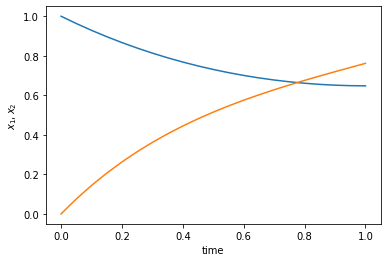

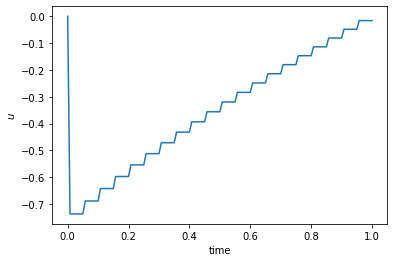

In [19]:
x1 = []
x2 = []
u = []
t = []

for i in sorted(m.t):
    t.append(i)
    x1.append(value(m.x1[i]))
    x2.append(value(m.x2[i]))
    u.append(value(m.u[i]))

plt.plot(t,x1)
plt.plot(t,x2)
plt.xlabel('time')
plt.ylabel('$x_{1}, x_{2}$')
plt.show()

plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('$u$')
plt.show()

### Credits:
 - David Thierry (Carnegie Mellon University @2019)